In [1]:
from crm import Network

In [2]:
import re
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [3]:
import dill
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        dill.dump(obj, outp, dill.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return dill.load(inp)

# Data

In [4]:
f = open("data/raw/crm_output.pl")

In [5]:
edges_raw = []

In [6]:
while True:
    s = f.readline()
    if not s:
        break
    if "connected" in s:
        edges_raw.append(s)

In [7]:
edges_raw[-2]

'connected(a(2),[a(0),a(0)],[1,0]).\n'

In [8]:
edges_raw[24].split(",")[0].split("(")[-1].split(")")[0]

'1258'

In [9]:
gg = ' '.join(edges_raw[24].split(",")[1:3])

In [10]:
gg

'[a(2) a(26)]'

In [11]:
int(re.findall(r"a\([0-9]*\)", gg)[0].split("(")[-1].split(")")[0])

2

In [12]:
int(re.findall(r"a\([0-9]*\)", gg)[1].split("(")[-1].split(")")[0])

26

In [13]:
edges = []

In [14]:
int(edges_raw[0].split(",")[0].split("(")[-1].split(")")[0])-1

1281

In [15]:
for i in range(len(edges_raw)):
    end = int(edges_raw[i].split(",")[0].split("(")[-1].split(")")[0])-1
    
    gg = ' '.join(edges_raw[i].split(",")[1:3])
    start_one = int(re.findall(r"a\([0-9]*\)", gg)[0].split("(")[-1].split(")")[0])-1
    start_two = int(re.findall(r"a\([0-9]*\)", gg)[1].split("(")[-1].split(")")[0])-1
    # start_one --> end
    # start_two --> end
    if start_one!=-1:
        edges.append((start_one, end))
    if start_two!=-1:
        edges.append((start_two, end))

In [16]:
with open("data/edges.txt", "w") as fp:
    for u, v in edges:
        fp.write(f"{u} {v}\n")

In [17]:
len(edges), len(set(edges))

(2518, 2518)

In [18]:
inputs = []
outputs = []

In [25]:
torch_dataset_inputs = torch.rand(700, 23)
for i in range(700):
    torch_dataset_inputs[i] = torch.tensor(list(inputs[i].values())[:23])

In [26]:
torch_dataset_outputs = torch.stack([outputs[i] for i in range(700)], dim=0)

In [19]:
f = open("data/raw/train_features_pos")

In [20]:
while True:
    gg = f.readline().split(" ")[3:-1]
    if not gg:
        break
    all_pos = [int(e) for e in gg]
    dd = {i: 1 if i in all_pos else 0 for i in range(1282)}
    inputs.append(dd)
    outputs.append(torch.tensor(1))

In [21]:
f = open("data/raw/train_features_neg")

In [22]:
while True:
    gg = f.readline().split(" ")[3:-1]
    if not gg:
        break
    all_pos = [int(e) for e in gg]
    dd = {i: 1 if i in all_pos else 0 for i in range(1282)}
    inputs.append(dd)
    outputs.append(torch.tensor(0))

In [23]:
num_neurons = max([max(u, v) for u, v in edges])+1

In [27]:
num_neurons

1282

In [28]:
adj_list = [[] for i in range(num_neurons)]

In [29]:
num_neurons

1282

In [30]:
len(adj_list)

1282

In [31]:
for u, v in edges:
    adj_list[u].append(v)

In [32]:
n = Network(num_neurons, adj_list)

In [33]:
orig_output_neurons = n.output_neurons

In [34]:
adj_list.append([])
adj_list.append([])

In [35]:
num_neurons = len(adj_list)

In [36]:
num_neurons

1284

In [37]:
for i in range(num_neurons):
    if i in orig_output_neurons:
        adj_list[i].append(num_neurons-2)
        adj_list[i].append(num_neurons-1)

In [38]:
adj_list[213]

[1282, 1283]

In [39]:
n = Network(num_neurons, adj_list)

In [40]:
n.set_neuron_activation(1282, lambda x : x, lambda x : 1)

In [41]:
n.set_neuron_activation(1283, lambda x : x, lambda x : 1)

In [42]:
F.cross_entropy

<function torch.nn.functional.cross_entropy(input: torch.Tensor, target: torch.Tensor, weight: Union[torch.Tensor, NoneType] = None, size_average: Union[bool, NoneType] = None, ignore_index: int = -100, reduce: Union[bool, NoneType] = None, reduction: str = 'mean', label_smoothing: float = 0.0) -> torch.Tensor>

In [43]:
dataset = [(inputs[i], outputs[i]) for i in range(len(inputs))]
random.shuffle(dataset)

In [44]:
random.shuffle(dataset)

  0%|          | 0/700 [00:00<?, ?it/s]

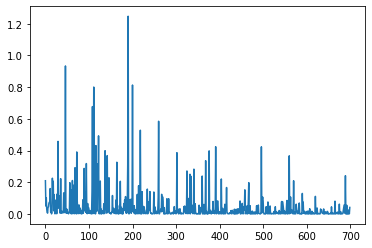

In [55]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    loss = F.cross_entropy(out, dataset[i][1].reshape(1))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    n.reset()
# print(n.weights)
plt.plot(losses)
plt.show()

In [47]:
n.reset()

In [46]:
dataset = [(inputs[i], outputs[i]) for i in range(len(inputs))]

In [47]:
random.shuffle(dataset)

In [48]:
dataset[21][1]

tensor(1)

In [49]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

100.0
[]


In [50]:
!pip install ipywidgets

     |████████████████████████████████| 121 kB 720 kB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 34.9 MB/s eta 0:00:01
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4


In [184]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

100.0
[]


In [49]:
!pip install dill

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [58]:
import dill

In [58]:
class Demo:
    def __init__(self):
        self.wow = 10
        self.damn = lambda x: 10*x

d = Demo()
with open('demo.pkl', 'wb') as f:
    dill.dump(d, f)

In [65]:
save_object(d, "demo.pkl")

In [66]:
d_dill_new =load_object("demo.pkl")

In [67]:
d_dill_new.damn(102)

1020

In [59]:
with open('demo.pkl', 'rb') as f:
    d_dill = dill.load(f)

In [62]:
d_dill.damn(10)

100

In [ ]:
dill.dump()

In [59]:
save_object(n, "network_100.pkl")

In [60]:
loaded_network_n = load_object("network_100.pkl")

In [70]:
loaded_network_n.reset()

In [71]:
optimizer = torch.optim.Adam(n.parameters(), lr=0.001)
losses = []
correct = 0
for i in trange(len(dataset)):
    f_mapper = dataset[i][0]
    f_mapper[1282]=1
    f_mapper[1283]=1
    out = loaded_network_n.forward(f_mapper).reshape(1, -1)
    correct += 1 if torch.argmax(out)==dataset[i][1] else 0
    loaded_network_n.reset()
print(correct/700*100)
# print(n.weights)
print(losses)
# plt.plot(losses)
# plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

100.0
[]


In [63]:
len(n.weights)

4992

In [64]:
save_object(n.weights, "weights_100.pkl")

In [45]:
w = load_object("weights_100.pkl")

In [46]:
n.weights = w

In [54]:
# https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function
import torch
for f in f_mapper_global:
    f[1282]=1
    f[1283]=1
    n.reset()
    o = n.forward(f)
    if o[0]!=torch.tensor([0.]):
        print(o)
        break

In [60]:
m = torch.nn.Sequential(torch.nn.Linear(10, 100))

In [72]:
list(m.parameters())[1]

Parameter containing:
tensor([ 0.2583, -0.2650, -0.1380,  0.2627, -0.0312,  0.1305, -0.2825,  0.2821,
        -0.1505, -0.1986,  0.1177, -0.0656, -0.2120,  0.2727,  0.2055,  0.2070,
         0.0710,  0.1732,  0.0441,  0.2178,  0.0877,  0.0890, -0.2641,  0.1323,
         0.2862,  0.1050, -0.0550,  0.0561,  0.1339,  0.1444, -0.1224,  0.0247,
        -0.2285, -0.1712,  0.2991,  0.2760,  0.3068, -0.2236,  0.1844,  0.2605,
         0.1401, -0.1417,  0.0496, -0.2446,  0.2426,  0.2560,  0.0176, -0.0214,
         0.0734, -0.2629, -0.1454, -0.0164, -0.2263, -0.1252,  0.2839,  0.1112,
        -0.1526, -0.2420,  0.1288, -0.2328, -0.1631, -0.2980, -0.2495,  0.0282,
         0.2589,  0.1794, -0.2060,  0.0578, -0.1831, -0.0485,  0.1794,  0.1493,
        -0.2882, -0.2283,  0.1230, -0.0346,  0.0167, -0.0178,  0.0618,  0.3064,
         0.2408, -0.1345,  0.1730,  0.0623,  0.2448,  0.2489,  0.2486, -0.2769,
         0.0622, -0.0840, -0.0709,  0.1767, -0.0693,  0.1541,  0.2729,  0.1055,
         0.1617, -

In [78]:
input_neurons = []
for neuron in n.neurons:
    if len(neuron.predeccesor_neurons)==0:
        input_neurons.append(neuron.n_id)

In [92]:
input_neurons

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

In [110]:
class MLP(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(inp_dim, 64), nn.ReLU(), nn.Linear(64, 32),nn.ReLU(), nn.Linear(32, 2))
    def forward(self, x):
        return self.mlp(x)

In [166]:
mlp = MLP(23, 2)

In [167]:
losses = []

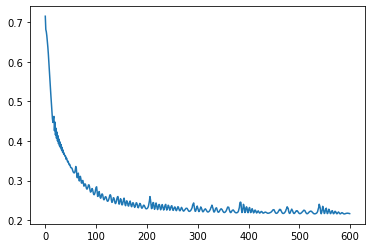

In [168]:
num_epochs = 600
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

for i in range(num_epochs):
    out = mlp(torch_dataset_inputs)
    loss = F.cross_entropy(out, torch_dataset_outputs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
plt.plot(losses)
plt.show()

In [169]:
losses[-1]

0.21631726622581482

In [170]:
trained_out = mlp(torch_dataset_inputs)

In [178]:
(torch.argmax(trained_out, dim=1) == torch_dataset_outputs).sum()

tensor(613)

In [179]:
613/700

0.8757142857142857

In [181]:
torch.jit.script(mlp).save("torch_model_87_57.pt")

In [191]:
mlp.mlp[0]

Linear(in_features=23, out_features=64, bias=True)

In [198]:
from captum.attr import LayerLRP
lrp = LayerLRP(mlp, mlp.mlp[0])
# Attribution size matches input size: 3x3x32x32
attribution = lrp.attribute(torch_dataset_inputs[0], target=1)

AssertionError: Cannot choose target column with output shape torch.Size([2]).

In [204]:
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

In [208]:
a, b = get_nth_key(n.weights, 132)
b

1203

In [52]:
for i in range(len(n.weights)):
    a, b = get_nth_key(n.weights, i)
    if a in input_neurons:
        print((a, b), n.weights[(a, b)])

In [50]:
n.output_neurons

[1282, 1283]

In [55]:
n.neurons[1283].value

tensor([63.4745], grad_fn=<MulBackward0>)

In [52]:
n.forward(dataset[0][0])

tensor([[58.5312],
        [63.4745]], grad_fn=<StackBackward0>)

In [54]:
dataset[0][1]

tensor(1)

In [56]:
n.lrp(torch.tensor(10), 1283)

In [61]:
n.neurons[1].relevance

tensor([0.], grad_fn=<AddBackward0>)

In [62]:
for i in range(24):
    print(i, n.neurons[i].relevance)

0 tensor([0.], grad_fn=<AddBackward0>)
1 tensor([0.], grad_fn=<AddBackward0>)
2 tensor([0.], grad_fn=<AddBackward0>)
3 tensor([0.], grad_fn=<AddBackward0>)
4 tensor([0.], grad_fn=<AddBackward0>)
5 tensor([0.], grad_fn=<AddBackward0>)
6 tensor([0.], grad_fn=<AddBackward0>)
7 tensor([0.], grad_fn=<AddBackward0>)
8 tensor([0.], grad_fn=<AddBackward0>)
9 tensor([0.], grad_fn=<AddBackward0>)
10 tensor([0.], grad_fn=<AddBackward0>)
11 tensor([0.], grad_fn=<AddBackward0>)
12 tensor([0.], grad_fn=<AddBackward0>)
13 tensor([0.], grad_fn=<AddBackward0>)
14 tensor([0.], grad_fn=<AddBackward0>)
15 tensor([0.3157], grad_fn=<AddBackward0>)
16 tensor([0.], grad_fn=<AddBackward0>)
17 tensor([0.7279], grad_fn=<AddBackward0>)
18 tensor([0.], grad_fn=<AddBackward0>)
19 tensor([1.3498], grad_fn=<AddBackward0>)
20 tensor([1.8116], grad_fn=<AddBackward0>)
21 tensor([2.3710], grad_fn=<AddBackward0>)
22 tensor([3.4239], grad_fn=<AddBackward0>)
23 tensor([1.3399], grad_fn=<AddBackward0>)
